In [ ]:
install.packages(c("readxl", "growthcurver", "ggplot2", "tidyr", "dplyr"))


The downloaded binary packages are in
	/var/folders/3q/3nlskyms4jn72307np8sw4n40000gn/T//RtmpkLU5yM/downloaded_packages


### RPMI 37


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "Background method min failed for 110"
[1] "Background method none failed for 110"
[1] "Processing sample: 110"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 110"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r_se"  "r_p"  
[10] "sigma" "df"    "t_mid" "t_gen" "auc_l" "auc_e" "note" 
k	k_se	k_p	n0	n0_se	n0_p
0.252	0.001	3e-114	0	0	1e-12

r	r_se	r_p	sigma	df	t_mid
0.734	0.013	4e-59	0.004	69	8.819

t_gen	auc_l	auc_e
0.945	3.828	3.86

[1] "AUC value: 3.8284826879556"
[1] "Doubling time value: 0.944656509527997"
[1] "Background method min failed for 111"
[1] "Background method none failed for 111"
[1] "Processing sample: 111"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 111"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r_se"  

agg_record_1676349569 
                    2

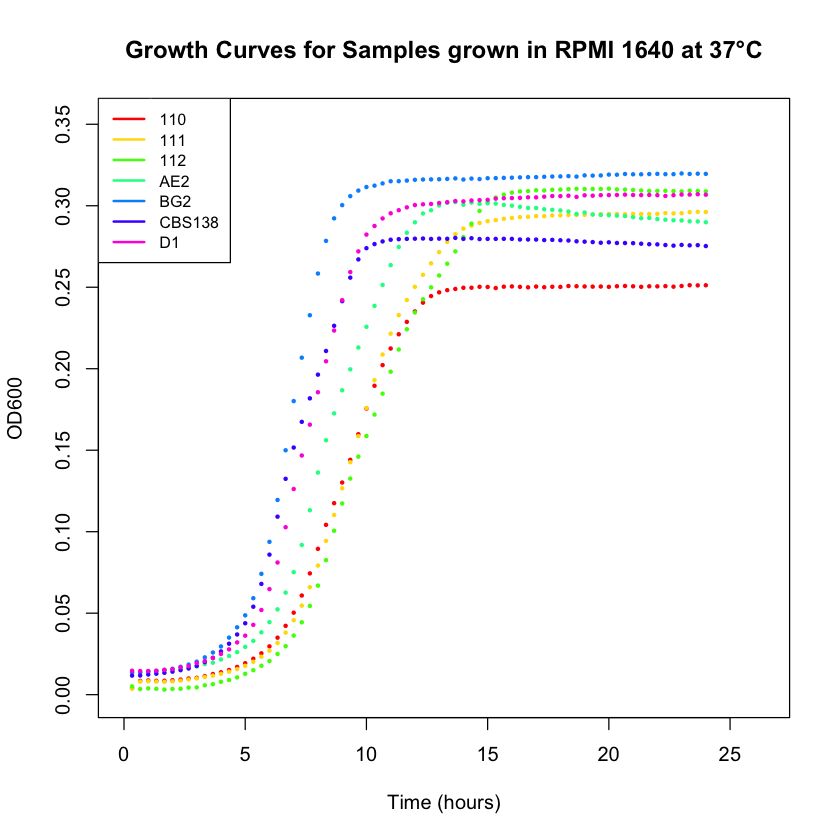

In [1]:
# Load packages
library(readxl)
library(growthcurver)
library(dplyr)

# Load the data
file_path <- "/Users/shriyan/Desktop/internship/PublishedProject/RPMI37/AGC_RPMI37.xlsx"
data = read_excel(path = file_path, sheet = "Sheet1")
# Remove any completely NA columns
data <- data[, colSums(is.na(data)) < nrow(data)]

# Remove rows where Time is NA
data <- data[!is.na(data$Time), ]

# Set up plot and result storage
plot_colors <- rainbow(ncol(data) - 1)
plot(NULL,
     xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
     ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
     xlab = "Time (hours)", ylab = "OD600",
     main = "Growth Curves for Samples grown in RPMI 1640 at 37°C")

growth_results <- list()
auc_results <- data.frame(Sample = character(), AUC = numeric(), Doubling_Time = numeric(), stringsAsFactors = FALSE)

# Loop through each sample
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  
  # Remove NA values
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]

  
  # Try to fit growth curve
  tryCatch({
   
    # Try fitting with different background correction methods
    fit <- NULL
    for (bg_method in c("min", "none")) {
      tryCatch({
        fit <- SummarizeGrowth(time_vals_clean, od_vals_clean, bg_correct = bg_method)
        if (!is.null(fit) && fit$sigma > 0) {
          print(paste("Successfully fit", sample_name, "with background method:", bg_method))
          break
        }
      }, error = function(e) {
        print(paste("Background method", bg_method, "failed for", sample_name))
      })
    }
    
    if (is.null(fit)) {
      print(paste("All fitting methods failed for", sample_name))
      # Plot raw data even if fitting fails
      points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      next
    }
    
    growth_results[[sample_name]] <- fit
    
    # Debug: Print the structure of fit to see available columns
    print(paste("Processing sample:", sample_name))
    print("Available columns in fit:")
    print(names(fit))
    print(paste("Fit quality (sigma):", fit$sigma))
    
    # Plot raw data points first
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    
    # Plot fitted curve if fit succeeded
    if (!is.null(fit$data)) {
      lines(fit$data$t, fit$data$y, col = plot_colors[i - 1], lwd = 2)
      print(paste("Successfully plotted fitted curve for", sample_name))
    } else {
      # If no fitted curve, just connect the raw points
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      print(paste("Plotted raw data line for", sample_name))
    }
    
    # Store AUC and Doubling Time - access from the vals data frame
    auc_value <- NA
    doubling_time_value <- NA
    
    # The parameters are stored in fit$vals
    if ("vals" %in% names(fit) && !is.null(fit$vals)) {
      print("Parameters in fit$vals:")
      print(names(fit$vals))
      print(fit$vals)
      
      # Check for AUC (
      if ("auc_l" %in% names(fit$vals) && !is.na(fit$vals$auc_l)) {
        auc_value <- fit$vals$auc_l
      } else if ("auc_e" %in% names(fit$vals) && !is.na(fit$vals$auc_e)) {
        auc_value <- fit$vals$auc_e
      }
      
      # Check for doubling time 
      if ("t_gen" %in% names(fit$vals) && !is.na(fit$vals$t_gen)) {
        doubling_time_value <- fit$vals$t_gen
      } else if ("dt_l" %in% names(fit$vals) && !is.na(fit$vals$dt_l)) {
        doubling_time_value <- fit$vals$dt_l
      }
    }
    
    # Print what we found
    print(paste("AUC value:", auc_value))
    print(paste("Doubling time value:", doubling_time_value))
    
    # Store results
    auc_results <- rbind(auc_results, data.frame(
      Sample = sample_name,
      AUC = auc_value,
      Doubling_Time = doubling_time_value,
      stringsAsFactors = FALSE
    ))
    
  }, error = function(e) {
    print(paste("Error processing sample", sample_name, ":", e$message))
    # Plot raw data even if fitting fails
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  })
}

# Add legend
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)

# Show AUC results
print("AUC/Doubling Time Results:")
print(auc_results)
# Save AUC results to a CSV file
write.csv(auc_results, "GC_results_RPMI37.csv", row.names = FALSE)
# Save the plot to a PNG file
png("GC_RPMI37.png", width = 1000, height = 800)
# Re-plot everything for the PNG output

plot(NULL,
  xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
  ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
  xlab = "Time (hours)", ylab = "OD",
  main = "Growth Curves for Samples grown in RPMI 1640 at 37°C")
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]
  points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
  if (!is.null(growth_results[[sample_name]]) && !is.null(growth_results[[sample_name]]$data)) {
    lines(growth_results[[sample_name]]$data$t, growth_results[[sample_name]]$data$y, col = plot_colors[i - 1], lwd = 2)
  } else {
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  }
}
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)
dev.off()

### RPMI 30


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "Background method min failed for 110"
[1] "Background method none failed for 110"
[1] "Processing sample: 110"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 110"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r_se"  "r_p"  
[10] "sigma" "df"    "t_mid" "t_gen" "auc_l" "auc_e" "note" 
k	k_se	k_p	n0	n0_se	n0_p
0.262	0.001	3e-115	0	0	2e-09

r	r_se	r_p	sigma	df	t_mid
0.915	0.019	1e-54	0.004	69	7.531

t_gen	auc_l	auc_e
0.758	4.313	4.334

[1] "AUC value: 4.31265251647063"
[1] "Doubling time value: 0.757740984474241"
[1] "Background method min failed for 111"
[1] "Background method none failed for 111"
[1] "Processing sample: 111"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 111"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r_se"

agg_record_1069858646 
                    2

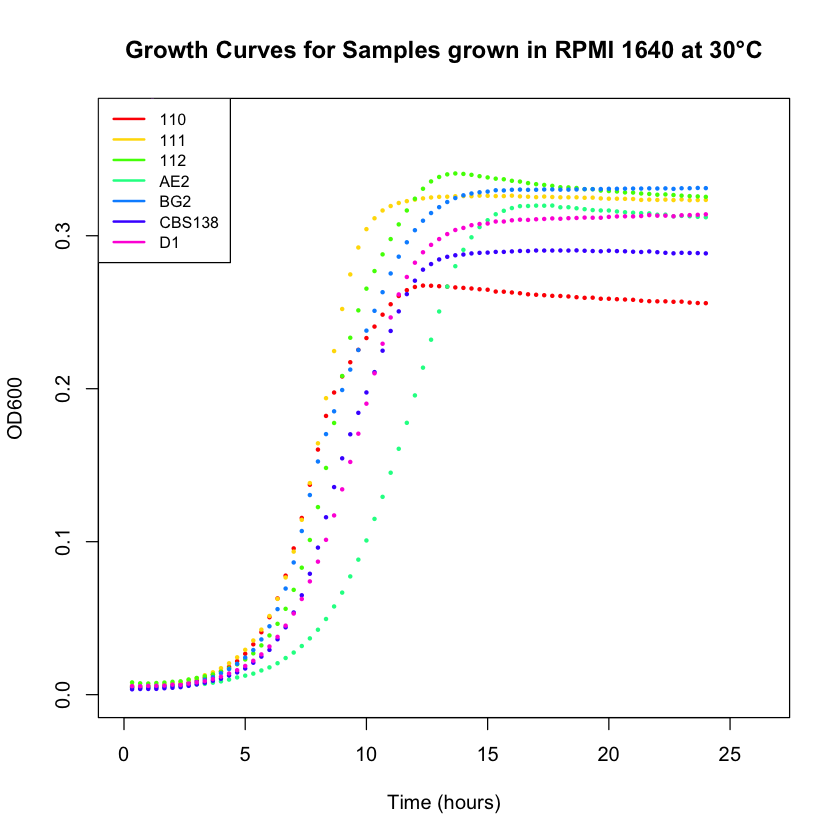

In [1]:
# Load packages
library(readxl)
library(growthcurver)
library(dplyr)

# Load the data
file_path <- "/Users/shriyan/Desktop/internship/PublishedProject/RPMI30/AGC_RPMI30.xlsx"
data = read_excel(path = file_path, sheet = "Sheet1")
# Remove any completely NA columns
data <- data[, colSums(is.na(data)) < nrow(data)]

# Remove rows where Time is NA
data <- data[!is.na(data$Time), ]

# Set up plot and result storage
plot_colors <- rainbow(ncol(data) - 1)
plot(NULL,
     xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
     ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
     xlab = "Time (hours)", ylab = "OD600",
     main = "Growth Curves for Samples grown in RPMI 1640 at 30°C")

growth_results <- list()
auc_results <- data.frame(Sample = character(), AUC = numeric(), Doubling_Time = numeric(), stringsAsFactors = FALSE)

# Loop through each sample
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  
  # Remove NA values
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]

  
  # Try to fit growth curve
  tryCatch({
   
    # Try fitting with different background correction methods
    fit <- NULL
    for (bg_method in c("min", "none")) {
      tryCatch({
        fit <- SummarizeGrowth(time_vals_clean, od_vals_clean, bg_correct = bg_method)
        if (!is.null(fit) && fit$sigma > 0) {
          print(paste("Successfully fit", sample_name, "with background method:", bg_method))
          break
        }
      }, error = function(e) {
        print(paste("Background method", bg_method, "failed for", sample_name))
      })
    }
    
    if (is.null(fit)) {
      print(paste("All fitting methods failed for", sample_name))
      # Plot raw data even if fitting fails
      points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      next
    }
    
    growth_results[[sample_name]] <- fit
    
    # Debug: Print the structure of fit to see available columns
    print(paste("Processing sample:", sample_name))
    print("Available columns in fit:")
    print(names(fit))
    print(paste("Fit quality (sigma):", fit$sigma))
    
    # Plot raw data points first
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    
    # Plot fitted curve if fit succeeded
    if (!is.null(fit$data)) {
      lines(fit$data$t, fit$data$y, col = plot_colors[i - 1], lwd = 2)
      print(paste("Successfully plotted fitted curve for", sample_name))
    } else {
      # If no fitted curve, just connect the raw points
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      print(paste("Plotted raw data line for", sample_name))
    }
    
    # Store AUC and Doubling Time - access from the vals data frame
    auc_value <- NA
    doubling_time_value <- NA
    
    # The parameters are stored in fit$vals
    if ("vals" %in% names(fit) && !is.null(fit$vals)) {
      print("Parameters in fit$vals:")
      print(names(fit$vals))
      print(fit$vals)
      
      # Check for AUC (
      if ("auc_l" %in% names(fit$vals) && !is.na(fit$vals$auc_l)) {
        auc_value <- fit$vals$auc_l
      } else if ("auc_e" %in% names(fit$vals) && !is.na(fit$vals$auc_e)) {
        auc_value <- fit$vals$auc_e
      }
      
      # Check for doubling time 
      if ("t_gen" %in% names(fit$vals) && !is.na(fit$vals$t_gen)) {
        doubling_time_value <- fit$vals$t_gen
      } else if ("dt_l" %in% names(fit$vals) && !is.na(fit$vals$dt_l)) {
        doubling_time_value <- fit$vals$dt_l
      }
    }
    
    # Print what we found
    print(paste("AUC value:", auc_value))
    print(paste("Doubling time value:", doubling_time_value))
    
    # Store results
    auc_results <- rbind(auc_results, data.frame(
      Sample = sample_name,
      AUC = auc_value,
      Doubling_Time = doubling_time_value,
      stringsAsFactors = FALSE
    ))
    
  }, error = function(e) {
    print(paste("Error processing sample", sample_name, ":", e$message))
    # Plot raw data even if fitting fails
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  })
}

# Add legend
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)

# Show AUC results
print("AUC/Doubling Time Results:")
print(auc_results)
# Save AUC results to a CSV file
write.csv(auc_results, "GC_results_RPMI30.csv", row.names = FALSE)
# Save the plot to a PNG file
png("GC_RPMI30.png", width = 1000, height = 800)
# Re-plot everything for the PNG output

plot(NULL,
  xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
  ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
  xlab = "Time (hours)", ylab = "OD600",
  main = "Growth Curves for Samples grown in RPMI 1640 at 30°C")
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]
  points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
  if (!is.null(growth_results[[sample_name]]) && !is.null(growth_results[[sample_name]]$data)) {
    lines(growth_results[[sample_name]]$data$t, growth_results[[sample_name]]$data$y, col = plot_colors[i - 1], lwd = 2)
  } else {
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  }
}
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)
dev.off()

### YPD 37


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "Background method min failed for 110"
[1] "Background method none failed for 110"
[1] "Processing sample: 110"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 110"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r_se"  "r_p"  
[10] "sigma" "df"    "t_mid" "t_gen" "auc_l" "auc_e" "note" 
k	k_se	k_p	n0	n0_se	n0_p
0.952	0.003	4e-114	0.002	0	2e-15

r	r_se	r_p	sigma	df	t_mid
0.655	0.011	2e-61	0.014	69	9.163

t_gen	auc_l	auc_e
1.059	14.12	14.086

[1] "AUC value: 14.1203943102749"
[1] "Doubling time value: 1.05865817366427"
[1] "Background method min failed for 111"
[1] "Background method none failed for 111"
[1] "Processing sample: 111"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 111"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r

agg_record_165446055 
                   2

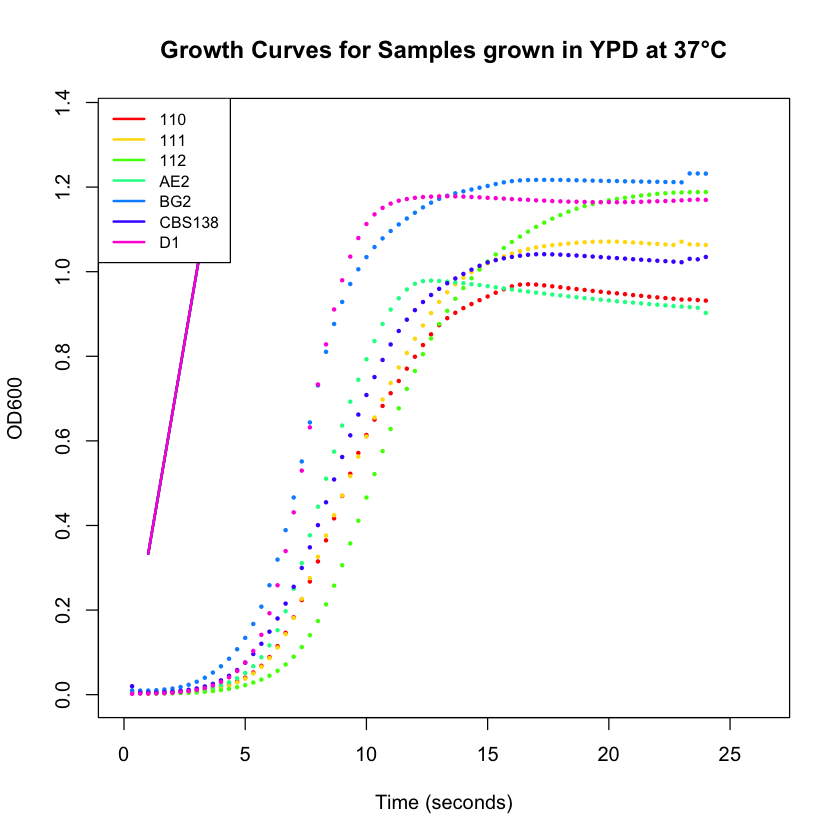

In [ ]:
# Load packages
library(readxl)
library(growthcurver)
library(dplyr)

# Load the data
file_path <- "/Users/shriyan/Desktop/internship/PublishedProject/YPD37/AGC_YPD37.xlsx"
data = read_excel(path = file_path, sheet = "Sheet1")
# Remove any completely NA columns
data <- data[, colSums(is.na(data)) < nrow(data)]

# Remove rows where Time is NA
data <- data[!is.na(data$Time), ]

# Set up plot and result storage
plot_colors <- rainbow(ncol(data) - 1)
plot(NULL,
     xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
     ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
     xlab = "Time (hours)", ylab = "OD600",
     main = "Growth Curves for Samples grown in YPD at 37°C")

growth_results <- list()
auc_results <- data.frame(Sample = character(), AUC = numeric(), Doubling_Time = numeric(), stringsAsFactors = FALSE)

# Loop through each sample
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  
  # Remove NA values
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]

  
  # Try to fit growth curve
  tryCatch({
   
    # Try fitting with different background correction methods
    fit <- NULL
    for (bg_method in c("min", "none")) {
      tryCatch({
        fit <- SummarizeGrowth(time_vals_clean, od_vals_clean, bg_correct = bg_method)
        if (!is.null(fit) && fit$sigma > 0) {
          print(paste("Successfully fit", sample_name, "with background method:", bg_method))
          break
        }
      }, error = function(e) {
        print(paste("Background method", bg_method, "failed for", sample_name))
      })
    }
    
    if (is.null(fit)) {
      print(paste("All fitting methods failed for", sample_name))
      # Plot raw data even if fitting fails
      points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      next
    }
    
    growth_results[[sample_name]] <- fit
    
    # Debug: Print the structure of fit to see available columns
    print(paste("Processing sample:", sample_name))
    print("Available columns in fit:")
    print(names(fit))
    print(paste("Fit quality (sigma):", fit$sigma))
    
    # Plot raw data points first
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    
    # Plot fitted curve if fit succeeded
    if (!is.null(fit$data)) {
      lines(fit$data$t, fit$data$y, col = plot_colors[i - 1], lwd = 2)
      print(paste("Successfully plotted fitted curve for", sample_name))
    } else {
      # If no fitted curve, just connect the raw points
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      print(paste("Plotted raw data line for", sample_name))
    }
    
    # Store AUC and Doubling Time - access from the vals data frame
    auc_value <- NA
    doubling_time_value <- NA
    # Sanity check: Skip flat curves
if (max(od_vals_clean, na.rm=TRUE) - min(od_vals_clean, na.rm=TRUE) < 0.1) {
  print(paste("Skipping", sample_name, "- OD too flat"))
  next
}
    # The parameters are stored in fit$vals
    if ("vals" %in% names(fit) && !is.null(fit$vals)) {
      print("Parameters in fit$vals:")
      print(names(fit$vals))
      print(fit$vals)
      
      # Check for AUC (
      if ("auc_l" %in% names(fit$vals) && !is.na(fit$vals$auc_l)) {
        auc_value <- fit$vals$auc_l
      } else if ("auc_e" %in% names(fit$vals) && !is.na(fit$vals$auc_e)) {
        auc_value <- fit$vals$auc_e
      }
      
      # Check for doubling time 
      if ("t_gen" %in% names(fit$vals) && !is.na(fit$vals$t_gen)) {
        doubling_time_value <- fit$vals$t_gen
      } else if ("dt_l" %in% names(fit$vals) && !is.na(fit$vals$dt_l)) {
        doubling_time_value <- fit$vals$dt_l
      }
    }
    
    # Print what we found
    print(paste("AUC value:", auc_value))
    print(paste("Doubling time value:", doubling_time_value))
    
    # Store results
    auc_results <- rbind(auc_results, data.frame(
      Sample = sample_name,
      AUC = auc_value,
      Doubling_Time = doubling_time_value,
      stringsAsFactors = FALSE
    ))
    
  }, error = function(e) {
    print(paste("Error processing sample", sample_name, ":", e$message))
    # Plot raw data even if fitting fails
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  })
}

# Add legend
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)

# Show AUC results
print("AUC/Doubling Time Results:")
print(auc_results)
# Save AUC results to a CSV file
write.csv(auc_results, "GC_results_YPD37.csv", row.names = FALSE)
# Save the plot to a PNG file
png("GC_YPD37.png", width = 1000, height = 800)
# Re-plot everything for the PNG output

plot(NULL,
  xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
  ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
  xlab = "Time (hours)", ylab = "OD600",
  main = "Growth Curves for Samples grown in YPD at 37°C")
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]
  points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
  if (!is.null(growth_results[[sample_name]]) && !is.null(growth_results[[sample_name]]$data)) {
    lines(growth_results[[sample_name]]$data$t, growth_results[[sample_name]]$data$y, col = plot_colors[i - 1], lwd = 2)
  } else {
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  }
}
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)
dev.off()

### YPD 30

[1] "Background method min failed for 110"
[1] "Background method none failed for 110"
[1] "Processing sample: 110"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 110"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "r_se"  "r_p"  
[10] "sigma" "df"    "t_mid" "t_gen" "auc_l" "auc_e" "note" 
k	k_se	k_p	n0	n0_se	n0_p
0.927	0.003	1e-112	0.001	0	3e-08

r	r_se	r_p	sigma	df	t_mid
0.888	0.019	3e-53	0.016	69	8.275

t_gen	auc_l	auc_e
0.78	14.572	14.583

[1] "AUC value: 14.5718320195608"
[1] "Doubling time value: 0.780227651711179"
[1] "Background method min failed for 111"
[1] "Background method none failed for 111"
[1] "Processing sample: 111"
[1] "Available columns in fit:"
[1] "vals"  "model" "data" 
[1] "Fit quality (sigma): "
[1] "Successfully plotted fitted curve for 111"
[1] "Parameters in fit$vals:"
 [1] "k"     "k_se"  "k_p"   "n0"    "n0_se" "n0_p"  "r"     "

agg_record_912365734 
                   2

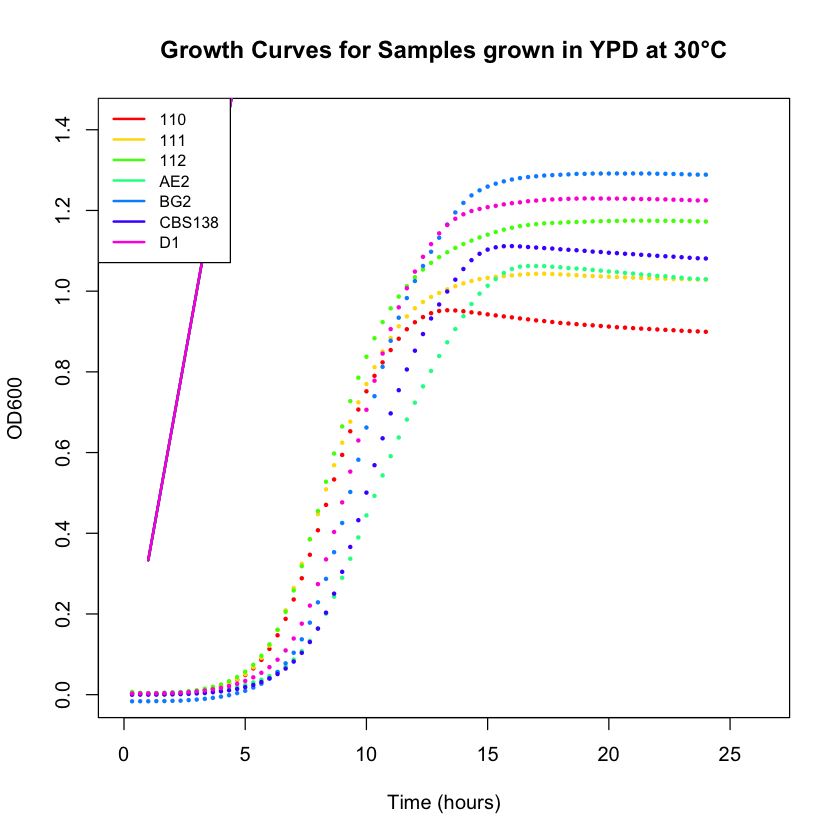

In [2]:
# Load packages
library(readxl)
library(growthcurver)
library(dplyr)

# Load the data
file_path <- "/Users/shriyan/Desktop/internship/PublishedProject/YPD 30/AGC_YPD30.xlsx"
data = read_excel(path = file_path, sheet = "Sheet1")
# Remove any completely NA columns
data <- data[, colSums(is.na(data)) < nrow(data)]

# Remove rows where Time is NA
data <- data[!is.na(data$Time), ]

# Set up plot and result storage
plot_colors <- rainbow(ncol(data) - 1)
plot(NULL,
     xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
     ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
     xlab = "Time (hours)", ylab = "OD600",
     main = "Growth Curves for Samples grown in YPD at 30°C")

growth_results <- list()
auc_results <- data.frame(Sample = character(), AUC = numeric(), Doubling_Time = numeric(), stringsAsFactors = FALSE)

# Loop through each sample
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  
  # Remove NA values
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]

  
  # Try to fit growth curve
  tryCatch({
   
    # Try fitting with different background correction methods
    fit <- NULL
    for (bg_method in c("min", "none")) {
      tryCatch({
        fit <- SummarizeGrowth(time_vals_clean, od_vals_clean, bg_correct = bg_method)
        if (!is.null(fit) && fit$sigma > 0) {
          print(paste("Successfully fit", sample_name, "with background method:", bg_method))
          break
        }
      }, error = function(e) {
        print(paste("Background method", bg_method, "failed for", sample_name))
      })
    }
    
    if (is.null(fit)) {
      print(paste("All fitting methods failed for", sample_name))
      # Plot raw data even if fitting fails
      points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      next
    }
    
    growth_results[[sample_name]] <- fit
    
    # Debug: Print the structure of fit to see available columns
    print(paste("Processing sample:", sample_name))
    print("Available columns in fit:")
    print(names(fit))
    print(paste("Fit quality (sigma):", fit$sigma))
    
    # Plot raw data points first
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    
    # Plot fitted curve if fit succeeded
    if (!is.null(fit$data)) {
      lines(fit$data$t, fit$data$y, col = plot_colors[i - 1], lwd = 2)
      print(paste("Successfully plotted fitted curve for", sample_name))
    } else {
      # If no fitted curve, just connect the raw points
      lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
      print(paste("Plotted raw data line for", sample_name))
    }
    
    # Store AUC and Doubling Time - access from the vals data frame
    auc_value <- NA
    doubling_time_value <- NA
    
    # The parameters are stored in fit$vals
    if ("vals" %in% names(fit) && !is.null(fit$vals)) {
      print("Parameters in fit$vals:")
      print(names(fit$vals))
      print(fit$vals)
      
      # Check for AUC (
      if ("auc_l" %in% names(fit$vals) && !is.na(fit$vals$auc_l)) {
        auc_value <- fit$vals$auc_l
      } else if ("auc_e" %in% names(fit$vals) && !is.na(fit$vals$auc_e)) {
        auc_value <- fit$vals$auc_e
      }
      
      # Check for doubling time 
      if ("t_gen" %in% names(fit$vals) && !is.na(fit$vals$t_gen)) {
        doubling_time_value <- fit$vals$t_gen
      } else if ("dt_l" %in% names(fit$vals) && !is.na(fit$vals$dt_l)) {
        doubling_time_value <- fit$vals$dt_l
      }
    }
    
    # Print what we found
    print(paste("AUC value:", auc_value))
    print(paste("Doubling time value:", doubling_time_value))
    
    # Store results
    auc_results <- rbind(auc_results, data.frame(
      Sample = sample_name,
      AUC = auc_value,
      Doubling_Time = doubling_time_value,
      stringsAsFactors = FALSE
    ))
    
  }, error = function(e) {
    print(paste("Error processing sample", sample_name, ":", e$message))
    # Plot raw data even if fitting fails
    points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  })
}

# Add legend
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)

# Show AUC results
print("AUC/Doubling Time Results:")
print(auc_results)
# Save AUC results to a CSV file
write.csv(auc_results, "GC_results_YPD30.csv", row.names = FALSE)
# Save the plot to a PNG file
png("GC_YPD30.png", width = 1000, height = 800)
# Re-plot everything for the PNG output

plot(NULL,
  xlim = c(0, max(data$Time, na.rm = TRUE) * 1.1),  
  ylim = c(0, max(data[,-1], na.rm = TRUE) * 1.1),  
  xlab = "Time (hours)", ylab = "OD600",
  main = "Growth Curves for Samples grown in YPD at 30°C")
for (i in 2:ncol(data)) {
  sample_name <- as.character(colnames(data)[i])
  time_vals <- data$Time
  od_vals <- data[[i]]
  valid_indices <- !is.na(time_vals) & !is.na(od_vals)
  time_vals_clean <- time_vals[valid_indices]
  od_vals_clean <- od_vals[valid_indices]
  points(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], pch = 16, cex = 0.5)
  if (!is.null(growth_results[[sample_name]]) && !is.null(growth_results[[sample_name]]$data)) {
    lines(growth_results[[sample_name]]$data$t, growth_results[[sample_name]]$data$y, col = plot_colors[i - 1], lwd = 2)
  } else {
    lines(time_vals_clean, od_vals_clean, col = plot_colors[i - 1], lwd = 2)
  }
}
legend("topleft", legend = colnames(data)[-1], col = plot_colors, lwd = 2, cex = 0.8)
dev.off()